In [1]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def sinusoid(x, x0, A, B, label):
    if label == 0:
        y = A*np.sin(x0 + B*x)
    elif label == 1:
        y = A*np.cos(x0 + B*x)
    return y

def get_sample(x_dim, label):
    x0 = uniform(low = 0, high = 1)
    #A = uniform(low = 0.5, high = 0.8)
    A = 1
    B = uniform(low = 1.2, high = 1.5)
    sample = np.array([sinusoid(item, x0, A, B, label) for item in np.linspace(0, 6*np.pi, x_dim)])
    return sample

In [4]:
x_dim = 64
sample_size = 50
np.random.seed(0)
labels = np.random.choice([0, 1], size = (sample_size), p = [0.5, 0.5])
print(f'labels: {labels}')
samples = np.stack([get_sample(x_dim, label) for label in labels])

labels: [1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1
 1 1 1 0 0 1 0 1 1 0 0 0 0]


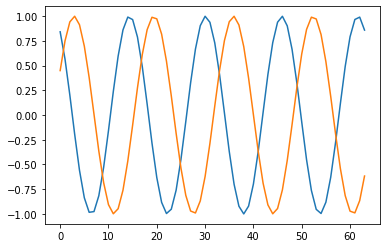

In [11]:
sample_idx = 0
plt.plot(samples[sample_idx]);
sample_idx = 4
plt.plot(samples[sample_idx]);

In [ ]:
import torch
from torch import nn, cat, optim, full, randn, no_grad
from tqdm.notebook import tqdm
import pandas as pd


class Generator(nn.Module):
    def __init__(self, dimLatent, classCount, dimEmbedding):
        super(Generator, self).__init__()
        self.dimLatent = dimLatent
        self.classCount = classCount
        self.dimEmbedding = dimEmbedding    #dimension of the embedding tensor
        self.labelEmbedding = nn.Embedding(num_embeddings = self.classCount, embedding_dim = dimEmbedding)  #NOTE: A bigger `embedding_dim` will be needed for >= 10 different labels!
        self.model = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = self.dimLatent + self.dimEmbedding, out_features = 64),
            #nn.ReLU(),
            nn.LeakyReLU(),
            # 2nd layer
            nn.Linear(in_features = 64, out_features = 128),
            #nn.ReLU(),
            nn.LeakyReLU(),
            # 3rd layer
            nn.Linear(in_features = 128, out_features = 64),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        x = self.model(cat((self.labelEmbedding(labels), noise), -1))   #apply model to concatenated tensor (fixed label tensor + noise tensor)
        return x


class Discriminator(nn.Module):
    def __init__(self, featureCount, classCount, dimEmbedding):
        super(Discriminator, self).__init__()
        self.featureCount = featureCount
        self.classCount = classCount
        self.dimEmbedding = dimEmbedding
        self.labelEmbedding = nn.Embedding(num_embeddings = self.classCount, embedding_dim = dimEmbedding)
        self.model = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = self.featureCount + self.dimEmbedding, out_features = 128),
            nn.LeakyReLU(),
            # 2nd layer
            nn.Linear(in_features = 128, out_features = 64),
            nn.LeakyReLU(),
            # 3rd layer
            nn.Linear(in_features = 64, out_features = 1),
            nn.Sigmoid()
        )
    
    def forward(self, data, labels):
        bool_ = self.model(cat((data, self.labelEmbedding(labels)), -1))
        return bool_


class GAN(object):
    def __init__(self, device, dataLoader, dimLatent, featureCount, classCount, dimEmbedding, lr, epochCount):
        self.device = device
        self.dataLoader = dataLoader
        self.dimLatent = dimLatent
        self.featureCount = featureCount
        self.classCount = classCount
        self.dimEmbedding = dimEmbedding
        self.lr = lr
        self.epochCount = epochCount

        # Initialize generator
        self.Gen = Generator(dimLatent, classCount, dimEmbedding)
        self.Gen.to(self.device)

        # Initialize discriminator
        self.Dis = Discriminator(featureCount, classCount, dimEmbedding)
        self.Dis.to(self.device)
    
        # Initialize optimizers
        self.optimGen = optim.Adam(params = self.Gen.parameters(), lr = self.lr)
        self.optimDis = optim.Adam(params = self.Dis.parameters(), lr = self.lr)

        # Initialize the loss function
        self.criterion = nn.BCELoss()

        self.df_loss = pd.DataFrame(columns = ['epoch', 'batch index', 'discriminator loss (real data)', 'discriminator loss (fake data)', 'discriminator loss', 'generator loss'])
        self.iterCount = 0
        self.noiseFixed = randn(1, dimLatent, device = device)
        self.labelsFixed = [torch.tensor([idx], dtype = torch.int32) for idx in range(classCount)]
    
    def train(self):
        for epoch in tqdm(range(self.epochCount)):
            for batchIdx, (data, target) in enumerate(self.dataLoader): #target = actual (real) label
                data = data.to(device = self.device, dtype = torch.float32)
                target = target.to(device = self.device)

                # Train discriminator with real data
                self.Dis.zero_grad()                                                                                            #set the gradients to zero for every mini-batch
                yReal = self.Dis(data, target)                                                                                  #train discriminator with real data
                labelReal = full(size = (data.size(0), 1), fill_value = 1, device = self.device, dtype = torch.float32)         #a tensor containing only ones
                lossDisReal = self.criterion(yReal, labelReal)                                                                  #calculate the loss
                lossDisReal.backward()                                                                                          #calculate new gradients

                # Train discriminator with fake data
                noise = randn(data.size(0), self.dimLatent, device = self.device)                                               #create a tensor filled with random numbers
                randomLabelFake = torch.randint(low = 0, high = self.classCount, size = (data.size(0),), device = self.device)  #random labels needed in addition to the noise
                labelFake = full(size = (data.size(0), 1), fill_value = 0, device = self.device, dtype = torch.float32)         #a tensor containing only zeros
                xFake = self.Gen(noise, randomLabelFake)                                                                        #create fake data from noise + random labels with generator
                yFake = self.Dis(xFake.detach(), randomLabelFake)                                                               #let the discriminator label the fake data (`.detach()` creates a copy of the tensor)
                lossDisFake = self.criterion(yFake, labelFake)
                lossDisFake.backward()

                lossDis = (lossDisReal + lossDisFake)                                                                           #compute the total discriminator loss
                self.optimDis.step()                                                                                            #update the discriminator

                # Train generator (now that we fed the discriminator with fake data)
                self.Gen.zero_grad()
                yFake_2 = self.Dis(xFake, randomLabelFake)                                                                      #let the discriminator label the fake data (now that the discriminator is updated)
                lossGen = self.criterion(yFake_2, labelReal)                                                                    #calculate the generator loss (small if the discriminator thinks that `yFake_2 == labelReal`)
                lossGen.backward()
                self.optimGen.step()

                # Log the progress
                self.df_loss.loc[len(self.df_loss)] = [epoch, batchIdx, lossDisReal.detach().cpu().numpy(), lossDisFake.detach().cpu().numpy(), lossDis.detach().cpu().numpy(), lossGen.detach().cpu().numpy()]
                if self.iterCount % 1000 == 0:
                    with no_grad():
                        for item in self.labelsFixed:
                            xFakeTest = self.Gen(self.noiseFixed, item)
                            plt.plot(xFakeTest.detach().cpu().numpy()[1])
                            plt.show();
                            yFakeTest = self.Dis(xFakeTest, item)
                            print(yFakeTest.detach().cpu().numpy().reshape(-1))
                self.iterCount += 1

In [50]:
samples.shape

(50, 64)

In [51]:
len(labels)

50

In [ ]:
#device = torch.device('cuda:0')
device = torch.device('cpu')
dataLoader = DataLoader(samples)
dimLatent = 8
featureCount = samples.shape[1]
lr = 1e-4
epochCount = 500

model = GAN(device, dataLoader, dimLatent, featureCount, lr, epochCount)
model.train()

In [ ]:
model.df_loss

In [ ]:
plt.plot(model.df_loss['generator loss'])

In [ ]:
plt.plot(model.df_loss['discriminator loss (real data)'])

In [ ]:
plt.plot(model.df_loss['discriminator loss (fake data)'])

In [ ]:
plt.plot(model.df_loss['discriminator loss'])